In [1]:
import os
import pandas as pd
import re
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
import string
from nltk.stem import WordNetLemmatizer
from gensim.models.phrases import Phrases, Phraser
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

[nltk_data] Downloading package stopwords to /Users/asa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/asa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df1 = pd.read_csv('/Users/asa/VScode/word2vec_kmeans/company_details.csv')
df2 = pd.read_csv('/Users/asa/VScode/word2vec_kmeans/opportunitiesALL_updated.csv')

df1['text'] = df1[['Description','Technology','Industry']].astype(str).agg(' '.join, axis=1)
df2['text'] = df2[['Tag','Introduction','Industry_Type', 'Description']].astype(str).agg(' '.join, axis=1)

df1['invetsed'] = df1['Inventors']  
df2['invetsed'] = df2['Invested']  
df1['coname'] = df1['Company Name']
df2['coname'] = df2['CoName']
df1['coname'] = df1['Company Name']
df2['coname'] = df2['CoName']
df1['industry'] = df1['Industry']
df2['industry'] = df2['Tag']

temp_df1 = df1[['text', 'invetsed','coname','industry']]
temp_df2 = df2[['text', 'invetsed','coname','industry']]
combined_df = pd.concat([temp_df1, temp_df2], ignore_index=True)

combined_df['text'] = combined_df['text'].replace('\n', ' ', regex=True)
combined_df['text'] = combined_df['text'].replace('nan', '', regex=True)

combined_df.dropna(subset=['text'], inplace=True)


# preprocess endding
# Bert training and vectorization

In [3]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT model and tokenizer
model_name = 'allenai/scibert_scivocab_uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
max_length = 512
# Function to encode text into embeddings using BERT
def bert_encode(texts):
    # Tokenize the text
    encoded_input = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
    # Forward pass, get hidden states
    with torch.no_grad():
        outputs = model(**encoded_input)
    # Obtain the embeddings from the last hidden state
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # Take the embeddings from the first token ([CLS])
    return embeddings

bert_embeddings = np.array([bert_encode([doc]) for doc in combined_df['text']])

/opt/miniconda3/envs/glove_kmeans/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
print(bert_embeddings.shape)
#print(tfidf_matrix.shape)

(1198, 1, 768)


# Drawing figure

/opt/miniconda3/envs/glove_kmeans/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/miniconda3/envs/glove_kmeans/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/miniconda3/envs/glove_kmeans/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/miniconda3/envs/glove_kmeans/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The defa

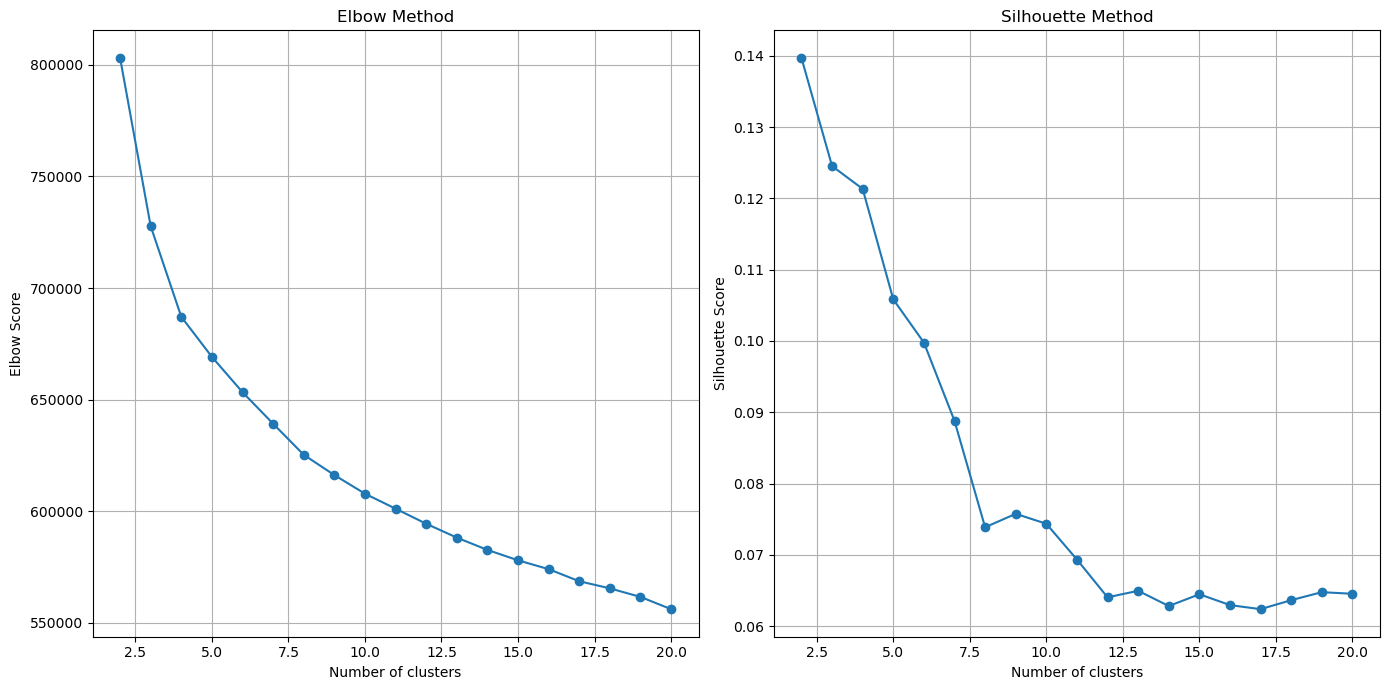

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 假设 bert_embeddings 是已经加载的数据，这里添加数据预处理步骤
# 对于大多数机器学习任务，标准化输入特征是一个良好的实践
bert_embeddings_reshaped = bert_embeddings.reshape(-1, bert_embeddings.shape[-1])
scaler = StandardScaler()
bert_embeddings_scaled = scaler.fit_transform(bert_embeddings_reshaped)


inertia = []
silhouette_scores = []

# 定义聚类数的范围
range_of_clusters = range(2, 21)

for n_clusters in range_of_clusters:
    try:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(bert_embeddings_scaled)
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(bert_embeddings_scaled, kmeans.labels_))
    except Exception as e:
        print(f"Error occurred for n_clusters={n_clusters}: {e}")
        continue

# 绘制图表
def plot_clusters(range_of_clusters, metric_values, metric_name):
    plt.plot(range_of_clusters, metric_values, marker='o')
    plt.title(f'{metric_name} Method')
    plt.xlabel('Number of clusters')
    plt.ylabel(f'{metric_name} Score')
    plt.grid(True)

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plot_clusters(range_of_clusters, inertia, 'Elbow')
plt.subplot(1, 2, 2)
plot_clusters(range_of_clusters, silhouette_scores, 'Silhouette')

plt.tight_layout()
plt.show()

In [11]:
# Choose the number of clusters
num_clusters = 9  # Adjust based on your needs

# Perform K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(bert_embeddings_scaled)
# Assign the cluster labels to your original DataFrame
combined_df['cluster'] = kmeans.labels_


/opt/miniconda3/envs/glove_kmeans/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


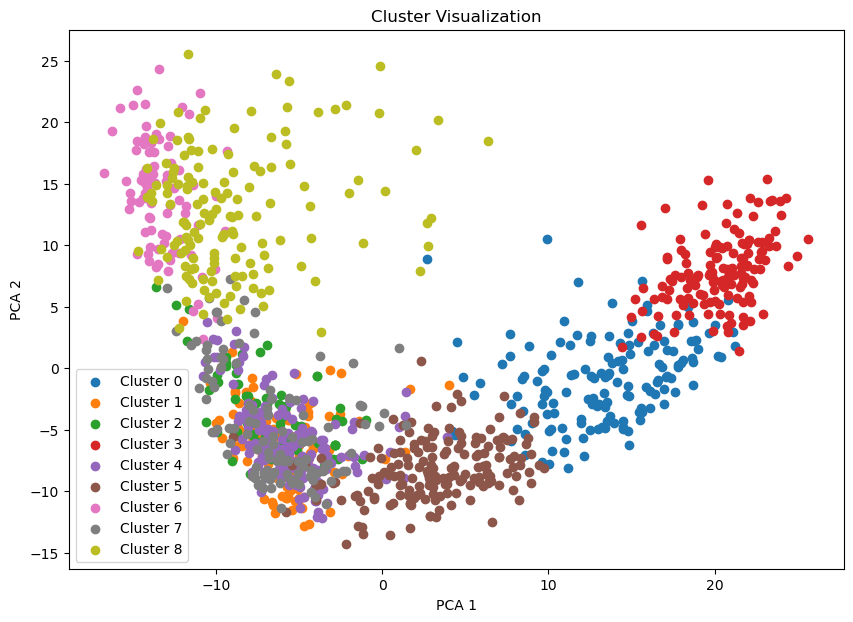

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(bert_embeddings_scaled)

# Plot the clusters
plt.figure(figsize=(10, 7))
for i in range(num_clusters):
    plt.scatter(reduced_vectors[kmeans.labels_ == i, 0], reduced_vectors[kmeans.labels_ == i, 1], label=f'Cluster {i}')
plt.legend()
plt.title('Cluster Visualization')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


In [13]:
import pandas as pd

# Assume 'combined_df' is your DataFrame containing the documents
# Assign cluster labels to each document based on the cluster assignments
combined_df['cluster_label'] = kmeans.labels_

# Save the DataFrame to a CSV file
combined_df.to_csv('label1_company.csv', index=False)

print("Cluster labels added and saved to CSV file.")


Cluster labels added and saved to CSV file.
